In [1]:
import sys
from src.consts import IN_COLAB, MAX_PADDING_SLICES, DATASET_MAX_BOUNDING_BOX, DESIRE_BOUNDING_BOX_SIZE

if IN_COLAB:
    print('Found Google Colab')
    !pip3 install torch torchvision torchsummary
    !pip3 install simpleitk

    # noinspection PyUnresolvedReferences
    from google.colab import drive
    drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import torch
import SimpleITK as sitk

import src.helpers.oars_labels_consts as OARS_LABELS

from operator import itemgetter
from IPython.display import display, Markdown
from ipywidgets import widgets
from importlib import reload

from src.training_helpers import loss_batch, show_model_info
from src.helpers.prepare_model import prepare_model
from src.helpers.train_loop import train_loop
from src.helpers.get_dataset import get_dataset, get_dataloaders, get_copy_dataloaders
from src.helpers.get_dataset_info import get_dataset_info
from src.helpers.preview_dataset import preview_dataset
from src.helpers.get_bounding_box import get_bounding_box, get_bounding_box_3D, get_bounding_box_3D_size, get_dividable_bounding_box, get_final_bounding_box_slice
from src.helpers.dataset_cut_helpers import get_full_res_cut
from src.helpers.show_model_dataset_pred_preview import show_model_dataset_pred_preview

torch.manual_seed(20)

print('Dataset biggest bounding box wihtout spinal cord', DATASET_MAX_BOUNDING_BOX)
print('Cut target size', DESIRE_BOUNDING_BOX_SIZE)
print('Done Init')

Dataset biggest bounding box wihtout spinal cord [56, 177, 156]
Cut target size [72, 192, 168]
Done Init


# Neural Network

## loading low res dataset

In [2]:
filter_labels = OARS_LABELS.OARS_LABELS_LIST
if OARS_LABELS.SPINAL_CORD in filter_labels:
    filter_labels.remove(OARS_LABELS.SPINAL_CORD)

low_res_dataset = get_dataset(dataset_size=50, shrink_factor=16, filter_labels=filter_labels, unify_labels=True)
low_res_dataset.dilatate_labels(repeat=1)
low_res_dataset.to_numpy()
low_res_dataset.show_data_type()
low_res_dataloaders_obj = get_dataloaders(low_res_dataset, train_size=40, valid_size=5, test_size=5)

get_dataset_info(low_res_dataset, low_res_dataloaders_obj)
train_low_res_dataset, valid_low_res_dataset, test_low_res_dataset = itemgetter('train_dataset', 'valid_dataset', 'test_dataset')(low_res_dataloaders_obj)

CUDA using 16x dataset
normalizing dataset
filtering labels
dilatating 1x dataset
parsing dataset to numpy
data type: float64 int8
train 40, valid_size 5, test 5, full 50
train indices [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 20, 21, 22, 23, 24, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
valid indices [6, 13, 19, 25, 38]
test indices [16, 26, 27, 29, 39]


In [3]:
preview_dataset(low_res_dataset, preview_index=0, show_hist=False)

data max 12.505709639268096, min -0.40698009878688973
label max 1, min 0


Output()

## training low res model

In [4]:
# preparing model loop params
low_res_model_info = prepare_model(epochs=30, in_channels=8, train_dataset=train_low_res_dataset, valid_dataset=valid_low_res_dataset, test_dataset=test_low_res_dataset)
show_model_info(low_res_model_info)

# getting everything necessary for model training
low_res_train_loop_params = {k:v for k,v in low_res_model_info.items() if k not in ['model_total_params', 'model_total_trainable_params']}
# running training loop
train_loop(**low_res_train_loop_params)

low_res_model = itemgetter('model')(low_res_model_info)

Device running "cuda"
max output channels 128
Model number of params: 1193537, trainable 1193537
Running training loop
Batch train [1] loss 0.97630, dsc 0.02370
Batch train [2] loss 0.97167, dsc 0.02833
Batch train [3] loss 0.97257, dsc 0.02743
Batch train [4] loss 0.96968, dsc 0.03032
Batch train [5] loss 0.97364, dsc 0.02636
Batch train [6] loss 0.96659, dsc 0.03341
Batch train [7] loss 0.95242, dsc 0.04758
Batch train [8] loss 0.96548, dsc 0.03452
Batch train [9] loss 0.96903, dsc 0.03097
Batch train [10] loss 0.96693, dsc 0.03307
Batch train [11] loss 0.96507, dsc 0.03493
Batch train [12] loss 0.97499, dsc 0.02501
Batch train [13] loss 0.95384, dsc 0.04616
Batch train [14] loss 0.95651, dsc 0.04349
Batch train [15] loss 0.95468, dsc 0.04532
Batch train [16] loss 0.96143, dsc 0.03857
Batch train [17] loss 0.96530, dsc 0.03470
Batch train [18] loss 0.96914, dsc 0.03086
Batch train [19] loss 0.96070, dsc 0.03930
Batch train [20] loss 0.96140, dsc 0.03860
Batch train [21] loss 0.95840,

## loading high/full res dataset

In [5]:
full_res_dataset = get_dataset(dataset_size=50, shrink_factor=1, filter_labels=filter_labels, unify_labels=False)
full_res_dataset.to_numpy()
full_res_dataset.show_data_type()
print('full dataset RAM sizes in GB', full_res_dataset.get_data_size())

preview_dataset(full_res_dataset, preview_index=0, show_hist=False)

print('dataset data and label shapes', low_res_dataset.data_list[0].shape, full_res_dataset.data_list[0].shape)

CUDA using 1x dataset
normalizing dataset
filtering labels
parsing dataset to numpy
data type: float64 int8
full dataset RAM sizes in GB 18874368000
data max 12.81577046544424, min -0.40489707167932215
label max 22, min 0


Output()

dataset data and label shapes (1, 160, 32, 32) (1, 160, 512, 512)


## testing precoarse network


In [6]:
# moving model to cpu and setting to eval mode, preventing model params changes/training
low_res_model.to('cpu')
low_res_model.eval()
print('moved model to cpu')

moved model to cpu


### getting bounding box cut in full res

In [7]:
def get_cut_lists(low_res_model, low_res_dataset, full_res_dataset, cut_full_res_dataset, low_res_mask_threshold=0.5):    
    for i in range(len(full_res_dataset)):
        print(f'getting cut index {i}')
        low_res_data_img = low_res_dataset.data_list[i]
        full_res_data_img = full_res_dataset.data_list[i]
        full_res_label_img = full_res_dataset.label_list[i]

        data_cut, label_cut, new_bounding_box = get_full_res_cut(low_res_model, 
                                                                 low_res_data_img, 
                                                                 full_res_data_img, 
                                                                 full_res_label_img, 
                                                                 low_res_mask_threshold,
                                                                 DESIRE_BOUNDING_BOX_SIZE, 
                                                                 show_debug=False)
        cut_full_res_dataset.data_list[i] = data_cut
        cut_full_res_dataset.label_list[i] = label_cut
        
    return cut_full_res_dataset

In [8]:
full_res_dataloaders_obj = get_copy_dataloaders(full_res_dataset, low_res_dataloaders_obj)
get_dataset_info(full_res_dataset, full_res_dataloaders_obj)

train 40, valid_size 5, test 5, full 50
train indices [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 20, 21, 22, 23, 24, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
valid indices [6, 13, 19, 25, 38]
test indices [16, 26, 27, 29, 39]


### debuging cut algorithm

In [9]:
low_res_mask_threshold = 0.5
dataset_index = 42
low_res_data_img = low_res_dataset.data_list[dataset_index]
full_res_data_img = full_res_dataset.data_list[dataset_index]
full_res_label_img = full_res_dataset.label_list[dataset_index]

data_cut, label_cut, new_bounding_box = get_full_res_cut(low_res_model, 
                                                         low_res_data_img,
                                                         full_res_data_img, 
                                                         full_res_label_img, 
                                                         low_res_mask_threshold,
                                                         DESIRE_BOUNDING_BOX_SIZE, 
                                                         show_debug=True)

debug box delta [28 32 24]
debug, does cut and original label contain the same amount of pixels? True 951804 951804
debug bounding box sizes (44, 160, 144) (72, 192, 168)
debug bounding boxes (65, 108, 160, 319, 176, 319) (51, 122, 144, 335, 164, 331)


Output()

Output()

### running cut algorithm, creating cut dataset

In [10]:
cut_full_res_dataset = full_res_dataset.copy(copy_lists=False)
cut_full_res_dataset = get_cut_lists(low_res_model, low_res_dataset, full_res_dataset, cut_full_res_dataset, low_res_mask_threshold=0.5)

getting cut index 0
debug box delta [22 32 24]
debug, does cut and original label contain the same amount of pixels? True 1223526 1223526
getting cut index 1
debug box delta [23 16 -8]
debug, does cut and original label contain the same amount of pixels? True 1326052 1326052
getting cut index 2
debug box delta [20  0 -8]
debug, does cut and original label contain the same amount of pixels? True 1890464 1890464
getting cut index 3
debug box delta [16 32  8]
debug, does cut and original label contain the same amount of pixels? True 1560217 1560217
getting cut index 4
debug box delta [21 32 -8]
debug, does cut and original label contain the same amount of pixels? True 1451227 1451227
getting cut index 5
debug box delta [21 32  8]
debug, does cut and original label contain the same amount of pixels? True 1262651 1262651
getting cut index 6
debug box delta [21 48 -8]
debug, does cut and original label contain the same amount of pixels? True 1566938 1566938
getting cut index 7
debug box delt

### reviewing full res and cut dataset

In [11]:
cut_full_res_dataset.show_data_type()
print()
print('full res shape', full_res_dataset.data_list[0].shape, full_res_dataset.label_list[0].shape)
print('cut full res shape', cut_full_res_dataset.data_list[0].shape, cut_full_res_dataset.label_list[0].shape)
print()
print('dataset RAM sizes in GB', full_res_dataset.get_data_size() / 1024**3, cut_full_res_dataset.get_data_size() / 1024**3)
print('single item RAM in GB', full_res_dataset.label_list[0].nbytes / 1024**3, full_res_dataset.data_list[0].nbytes / 1024**3)
print()
preview_dataset(cut_full_res_dataset, max_slices=72)

data type: float64 int8

full res shape (1, 160, 512, 512) (160, 512, 512)
cut full res shape (1, 72, 192, 168) (72, 192, 168)

dataset RAM sizes in GB 17.578125 0.9733200073242188
single item RAM in GB 0.0390625 0.3125

data max 11.780218856954171, min -0.42423961281850314
label max 22, min 0


Output()

### preparing cut model

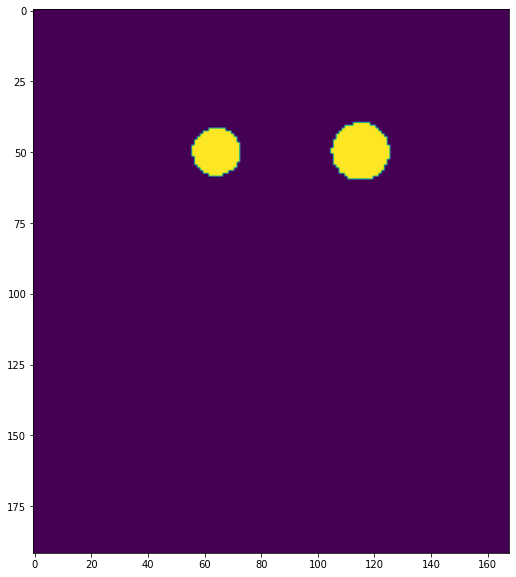

train 40, valid_size 5, test 5, full 50
train indices [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 20, 21, 22, 23, 24, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
valid indices [6, 13, 19, 25, 38]
test indices [16, 26, 27, 29, 39]


In [12]:
cut_full_res_dataset.set_output_label([OARS_LABELS.EYE_L, OARS_LABELS.EYE_R, OARS_LABELS.LENS_L, OARS_LABELS.LENS_R])
plt.figure(figsize=(10, 10))
plt.imshow(cut_full_res_dataset.__getitem__(0)[1][47])
plt.show()

cut_dataloaders_obj = get_copy_dataloaders(cut_full_res_dataset, low_res_dataloaders_obj)
get_dataset_info(cut_full_res_dataset, cut_dataloaders_obj)

cut_train_dataset, cut_valid_dataset, cut_test_dataset = itemgetter('train_dataset', 'valid_dataset', 'test_dataset')(cut_dataloaders_obj)

In [13]:
cut_model_info = prepare_model(in_channels=8, train_dataset=cut_train_dataset, valid_dataset=cut_valid_dataset, test_dataset=cut_test_dataset)
show_model_info(cut_model_info)

cut_train_loop_params = {k:v for k,v in cut_model_info.items() if k not in ['model_total_params', 'model_total_trainable_params']}
train_loop(**cut_train_loop_params)

Device running "cuda"
max output channels 128
Model number of params: 1193537, trainable 1193537
Running training loop
Batch train [1] loss 0.99714, dsc 0.00286
Batch train [2] loss 0.99630, dsc 0.00370
Batch train [3] loss 0.99535, dsc 0.00465
Batch train [4] loss 0.99437, dsc 0.00563
Batch train [5] loss 0.99417, dsc 0.00583
Batch train [6] loss 0.99105, dsc 0.00895
Batch train [7] loss 0.99187, dsc 0.00813
Batch train [8] loss 0.98926, dsc 0.01074
Batch train [9] loss 0.99563, dsc 0.00437
Batch train [10] loss 0.99328, dsc 0.00672
Batch train [11] loss 0.99012, dsc 0.00988
Batch train [12] loss 0.98951, dsc 0.01049
Batch train [13] loss 0.99407, dsc 0.00593
Batch train [14] loss 0.98940, dsc 0.01060
Batch train [15] loss 0.99217, dsc 0.00783
Batch train [16] loss 0.99089, dsc 0.00911
Batch train [17] loss 0.99018, dsc 0.00982
Batch train [18] loss 0.99227, dsc 0.00773
Batch train [19] loss 0.99314, dsc 0.00686
Batch train [20] loss 0.99174, dsc 0.00826
Batch train [21] loss 0.98874,

In [19]:
from src.training_helpers import iterate_model

train_loss, train_dsc = iterate_model(cut_train_loop_params["train_dataloader"], cut_train_loop_params["model"], cut_train_loop_params["optimizer"], cut_train_loop_params["criterion"], cut_train_loop_params["device"], is_eval=False)

Batch train [1] loss 0.13134, dsc 0.86866
Batch train [2] loss 0.12497, dsc 0.87503
Batch train [3] loss 0.11860, dsc 0.88140
Batch train [4] loss 0.10048, dsc 0.89952
Batch train [5] loss 0.11291, dsc 0.88709
Batch train [6] loss 0.13088, dsc 0.86912
Batch train [7] loss 0.18721, dsc 0.81279
Batch train [8] loss 0.11802, dsc 0.88198
Batch train [9] loss 0.13769, dsc 0.86231
Batch train [10] loss 0.11462, dsc 0.88538
Batch train [11] loss 0.11791, dsc 0.88209
Batch train [12] loss 0.14669, dsc 0.85331
Batch train [13] loss 0.16311, dsc 0.83689
Batch train [14] loss 0.14313, dsc 0.85687
Batch train [15] loss 0.14085, dsc 0.85915
Batch train [16] loss 0.14378, dsc 0.85622
Batch train [17] loss 0.13012, dsc 0.86988
Batch train [18] loss 0.11089, dsc 0.88911
Batch train [19] loss 0.08718, dsc 0.91282
Batch train [20] loss 0.15705, dsc 0.84295
Batch train [21] loss 0.11444, dsc 0.88556
Batch train [22] loss 0.10427, dsc 0.89573
Batch train [23] loss 0.11995, dsc 0.88005
Batch train [24] los

In [21]:
valid_loss, valid_dsc = iterate_model(cut_train_loop_params["valid_dataloader"], cut_train_loop_params["model"], cut_train_loop_params["optimizer"], cut_train_loop_params["criterion"], cut_train_loop_params["device"], is_eval=True)

Batch eval [1] loss 0.18210, dsc 0.81790
Batch eval [2] loss 0.42156, dsc 0.57844
Batch eval [3] loss 0.24926, dsc 0.75074
Batch eval [4] loss 0.11918, dsc 0.88082
Batch eval [5] loss 0.27942, dsc 0.72058


160x128x128 = 2_621_440 \
72x198x168 = 2_395_008

### Cut Model evaluation

#### Train Eval

showing number 31
loss 0.2326015830039978, dsc 0.7673984169960022, inputs_len 1


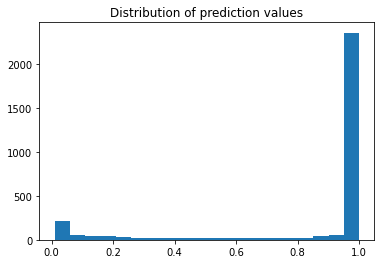

Output()

DEBUG shapes torch.Size([1, 72, 192, 168]) torch.Size([1, 72, 192, 168]) torch.Size([1, 1, 72, 192, 168])
DEBUG prediction max 1.0, min 6.080886123527307e-06
DEBUG intersection 2587.37060546875
DEBUG label sum 3871.0
DEBUG prediction sum 2872.236328125
DEBUG intersection2 2587.37060546875
DEBUG dsc 0.7673972845077515
DEBUG MSE 0.0005200004670768976


In [22]:
max_slices = cut_train_dataset.__getitem__(0)[1].shape[0]

display(Markdown("#### Train Eval"))
show_model_dataset_pred_preview(cut_model_info, cut_train_dataset, max_slices=max_slices, default_slice=49)

# display(Markdown("#### Valid Eval"))
# show_model_dataset_pred_preview(cut_model_info, cut_valid_dataset, max_slices=max_slices, default_slice=53)

# display(Markdown("#### Test Eval"))
# eval_image_dataset(test_dataset, 78, 'test_plot.png')

### calculating best threshold

In [23]:
from src.helpers.calc_dsc import calc_dsc
import pandas as pd

def get_rescaled_preds(model, dataset, device):
    preds = []
    rescaled_preds = []
    for i in range(len(dataset)):
        data, label = dataset[i]
        data_input = torch.from_numpy(np.array([data])).to(device).float()
        # data_input.shape => batch, channel, slices, x, y

        prediction = model(data_input)[0]
        prediction = prediction.cpu().detach().numpy()[0]
        rescaled_pred = prediction - prediction.min()
        rescaled_pred = rescaled_pred / rescaled_pred.max()
        
        preds.append(prediction)
        rescaled_preds.append(rescaled_pred)
        
    return preds, rescaled_preds, 


def get_dataset_threshold_info(dataset, preds, rescaled_preds, index, info_list, is_train=False, is_valid=False, is_test=False):
    data, label = dataset[index]
    prediction = preds[index]
    rescaled_pred = rescaled_preds[index]
    
    info = {}
    info['index'] = index
    info['dsc'] = calc_dsc(label, prediction)
    info['rescaled_dsc'] = calc_dsc(label, rescaled_pred)
    info['is_train'] = is_train
    info['is_valid'] = is_valid
    info['is_test'] = is_test
    
    step = 0.01
    for thresh in np.arange(0, 1 + step, step):
        tmp_text = "{:.2f}".format(thresh)
        info[f'thres_rescaled_dsc_{tmp_text}'] = calc_dsc(label, (rescaled_pred > thresh) * 1)
        
    info_list.append(info)
    return info_list


def get_threshold_info_df(model, dataset, device, train_indices, valid_indices, test_indices):
    preds, rescaled_preds = get_rescaled_preds(model, dataset, device)
    info_list = []

    # get table with dsc, rescaled dsc and treshold dsc with some steps, with subset info
    print('starting calc dsc per threshold')
    for index in list(sorted(train_indices)):
        info_list = get_dataset_threshold_info(dataset, preds, rescaled_preds, index, info_list, is_train=True)
    print('done train')
    for index in list(sorted(valid_indices)):
        info_list = get_dataset_threshold_info(dataset, preds, rescaled_preds, index, info_list, is_valid=True)
    print('done valid')
    for index in list(sorted(test_indices)):
        info_list = get_dataset_threshold_info(dataset, preds, rescaled_preds, index, info_list, is_test=True)
    print('done test')
    info_df = pd.DataFrame(info_list).set_index('index')
    
    return info_df, preds, rescaled_preds


starting calc dsc per threshold
done train
done valid
done test
----------- Curve


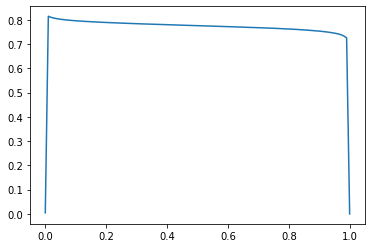


----------- Best Threshold
dsc on train: 0.8147569037995362, threshold 0.01

----------- Eval
--valid--


index
6     0.832812
13    0.700683
19    0.800531
25    0.906688
38    0.889212
Name: thres_rescaled_dsc_0.01, dtype: float64

Results DSC: train 0.8147569037995364 valid 0.8259851907221035


In [24]:
cut_model_info["model"].eval()
with torch.no_grad():
    info_df, preds, rescaled_preds = get_threshold_info_df(cut_model_info["model"], cut_full_res_dataset, cut_model_info["device"], cut_train_dataset.indices, cut_valid_dataset.indices, cut_test_dataset.indices)

    # getting mean dsc for each treshold
    train_tmp_df = info_df[info_df['is_train']]

    mean_train_tmp_df = train_tmp_df.mean().copy().drop(['dsc', 'rescaled_dsc', 'is_train', 'is_valid', 'is_test'])
    mean_train_tmp_df.index = mean_train_tmp_df.index.str.split('_').map(lambda x: eval(x[-1]))

    # print('----------- Sorted by threshold value')
    # display(mean_train_tmp_df)
    # print()

    # print('----------- Sorted by average DSC')
    # display(mean_train_tmp_df.sort_values())
    # print()

    print('----------- Curve')
    mean_train_tmp_df.plot()
    plt.show()
    print()
    print('----------- Best Threshold')
    best_threshold = mean_train_tmp_df.index[mean_train_tmp_df.argmax()]
    print(f'dsc on train: {mean_train_tmp_df.max()}, threshold {best_threshold}')
    print()
    # final results with best treshold
    print('----------- Eval')
    best_threshold_column = f'thres_rescaled_dsc_{best_threshold}'
    train_tmp = info_df[info_df['is_train']][best_threshold_column]
    valid_tmp = info_df[info_df['is_valid']][best_threshold_column]
    # test_tmp = info_df[info_df['is_test']][best_threshold_column]

    #print('--train--')
    #display(train_tmp)
    print('--valid--')
    display(valid_tmp)
    # print('--test--')
    # display(test_tmp)

    print(f'Results DSC: train {train_tmp.mean()} valid {valid_tmp.mean()}')

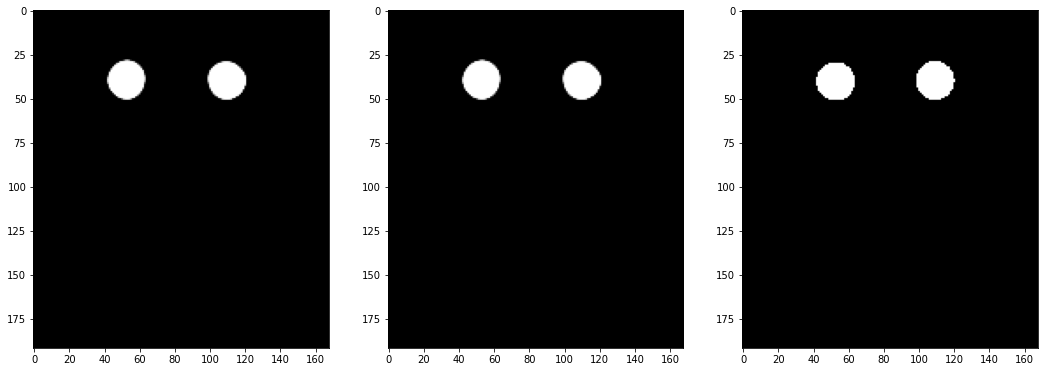

In [26]:
dataset_index = 40
slice_index = 49

plt.figure(figsize=(18, 12))
plt.subplot(1, 3, 1)
plt.imshow(preds[dataset_index][slice_index], cmap="gray", vmin=0, vmax=1)

plt.subplot(1, 3, 2)
plt.imshow(rescaled_preds[dataset_index][slice_index], cmap="gray", vmin=0, vmax=1)

plt.subplot(1, 3, 3)
plt.imshow(cut_full_res_dataset[dataset_index][1][slice_index], cmap="gray", vmin=0, vmax=1)
plt.show()